# Part 1: Linear Regression

In [1]:
# Execute this code block to install dependencies when running on colab
try:
    import torch
except:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl torchvision

## Getting started 

At its heart, PyTorch is just a library for manipulating tensors. We're going to start learning how to use 
PyTorch by looking at how we can implement simple linear regression. 

Code speaks better than words, so lets start by looking at a bit of pytorch code to generate some 2d data to regress:

In [2]:
import torch

# Generate some data points on a straight line perturbed with Gaussian noise
N = 1000 # number of points
theta_true = torch.Tensor([[1.5], [2.0]]) # true parameters of the line

X = torch.rand(N, 2) 
X[:, 1] = 1.0
y = X @ theta_true + 0.1 * torch.randn(N, 1) 
# Note that just like in numpy '@' represents matrix multiplication and A@B is equivalent to torch.mm(A, B) 

The above code generates $(x,y)$ data according to $y = 1.5x + 2$, with the $x$'s chosen from a uniform distribution. The $y$'s are additionally purturbed by adding an amount $0.1z$, where $z\sim \mathcal{N}(0,1)$ is a sample from a standard normal distribution. 

Note that we represent our $x$'s as a two-dimensional (row) vector with a 1 in the second element so that the offset can be rolled into the matrix multiplication for efficiency:

\begin{align}
    y &= \mathbf{X}\begin{bmatrix}
           1.5 \\
           2
         \end{bmatrix}
  \end{align}

Let's use `matplotlib` to draw a scatter so we can be sure of what our data looks like:

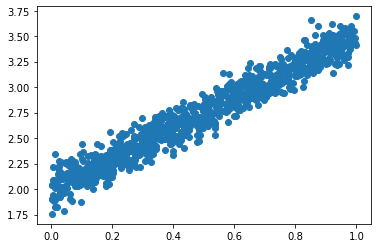

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.scatter(X[:,0].numpy(), y.numpy())
plt.show()

__Make sure you understand how the code above is generating data; feel free to change the parameters to see what effect they have.__

Now, lets consider the situation where we have been given the tensors $X$ and $y$ and wish to compute the regression parameters. Our model looks like $\mathbf{y} = \mathbf{X\theta}$, and we wish to recover the parameters $\theta$. 

As the problem is both overcomplete (only two data pairs are required to find $\theta$), and the data is noisy, we can use the Moore-Penrose Pseudoinverse to find the least-squares solution to $\theta$: $\theta = \mathbf{X^+y}$. PyTorch has a built-in pseudoinverse method (`pinverse`) that can do all the work for us:

In [5]:
# direct solution using moore-penrose pseudo inverse
X_inv = torch.pinverse(X)
theta_pinv = torch.mm(X_inv, y)
print(theta_pinv)

tensor([[1.4986],
        [2.0018]])


Running the above code should give you a solution vector for $\theta$ that is very similar to the true parameter vector (`theta_true`). 

## Exercise: computing the pseudoinverse from the Singular Value Decomposition.

The standard way of computing the pseudoinverse is by using the Singular Value Decomposition (SVD). The SVD is defined as: $\mathbf{X} = \mathbf{U}\Sigma\mathbf{V}^\top$. The pseudoinverse is thus $\mathbf{X}^+ = \mathbf{V}\Sigma^{-1}\mathbf{U}^\top$ where $\Sigma^{-1}$ is a diagonal matrix in which the reciprocal of the corresponding non-zero elements in $\Sigma$ has been taken.

__Use the code block below to compute the parameter vector using the SVD directly rather than the through the `pinverse` method.__ You need to store your manually computed pseudoinverse in `X_inv_svd`. Useful methods will be `torch.svd()` to compute the SVD, `[Tensor].t()` to transpose a matrix and `torch.diag()` to form a diagonal matrix from a vector.

In [6]:
# YOUR CODE HERE
# raise NotImplementedError()
uu,ss,vv = torch.svd(X)
print(X)
print(uu)
print(ss)
print(vv)
print(X.size())
print(uu.size())
print(ss.size())
print(vv.size())
print('____________________________________')
VV = vv.t()
print(VV)
print(VV.size())
SS = torch.diag(ss)
print(SS)
SS= torch.pinverse(SS)
print(SS)
print(SS.size())
UU = uu.t()
print(UU)
print(UU.size())
X_inv_svd = torch.mm(torch.mm(VV,SS),UU)
print(X_inv_svd)
theta_pinv_svd = torch.mm(X_inv_svd, y)
print(theta_pinv_svd)

tensor([[0.7457, 1.0000],
        [0.0638, 1.0000],
        [0.1882, 1.0000],
        ...,
        [0.8005, 1.0000],
        [0.5988, 1.0000],
        [0.0663, 1.0000]])
tensor([[-0.0347,  0.0230],
        [-0.0256, -0.0509],
        [-0.0273, -0.0374],
        ...,
        [-0.0354,  0.0289],
        [-0.0327,  0.0071],
        [-0.0257, -0.0506]])
tensor([35.5793,  8.1489])
tensor([[-0.4708,  0.8822],
        [-0.8822, -0.4708]])
torch.Size([1000, 2])
torch.Size([1000, 2])
torch.Size([2])
torch.Size([2, 2])
____________________________________
tensor([[-0.4708, -0.8822],
        [ 0.8822, -0.4708]])
torch.Size([2, 2])
tensor([[35.5793,  0.0000],
        [ 0.0000,  8.1489]])
tensor([[0.0281, 0.0000],
        [0.0000, 0.1227]])
torch.Size([2, 2])
tensor([[-0.0347, -0.0256, -0.0273,  ..., -0.0354, -0.0327, -0.0257],
        [ 0.0230, -0.0509, -0.0374,  ...,  0.0289,  0.0071, -0.0506]])
torch.Size([2, 1000])
tensor([[-0.0020,  0.0058,  0.0044,  ..., -0.0027, -0.0003,  0.0058],
        [-

In [6]:
torch.all(torch.lt(torch.abs(torch.add(theta_pinv, -theta_pinv_svd)), 1e-6))

tensor(False)

## Gradient based Linear Regression

Fundamentally, with linear regression we are trying to find a solution vector, $theta$ that minimises $f(\theta) = 0.5\|\mathbf{X}\theta - \mathbf{y}\|_2^2$. 

We've already seen how this can be minimised directly using the pseudoinverse, but it could also be minimised by using gradient descent: $\theta \gets \theta - \alpha f'(\theta)$. (_Interesting aside_: SVD (and thus the pseudoinverse) can also be solved using gradient methods - in fact this becomes the only practical way for really large matrices.).

__Use the following block to derive and write down the gradient, $f'(\theta)$, of $f(\theta)$__. Note that you can insert latex code by wrapping expressions in dollar symbols.

__Now complete the following code block to implement your gradient as pytorch code:__

In [7]:
def linear_regression_loss_grad(theta, X, y):
    X0 = X.t()
    grad  = torch.mm(X0,(torch.mm(X,theta)-y))
    # theta, X and y have the same shape as used previously
    return grad

linear_regression_loss_grad(torch.zeros(2,1), X, y).shape == (2,1)

True

Now we can plug that gradient function into a basic gradient descent solver and check that the solution is close to what we get with the pseudoinverse:

In [8]:
alpha = 0.001
theta = torch.Tensor([[0], [0]])
for e in range(0, 200):
    gr = linear_regression_loss_grad(theta, X, y)
    theta -= alpha * gr

print(theta)

tensor([[1.4986],
        [2.0018]])


## Real data

Doing linear regression on synthetic data is a great way to understand how PyTorch works, but it isn't quite as satisfying as working with a real dataset. Let's now apply or understanding of computing linear regression parameters to a dataset of house prices in Boston.

We'll load the dataset using scikit-learn and perform some manipulations in the following code block:

In [9]:
import pandas as pd
import numpy as np
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]
X = torch.Tensor(data) #convert to pytorch Tensors
y = torch.Tensor(target)

X = X[:, [2,5]] # We're just going to use features 2 and 5, rather than using all of of them
X = torch.cat((X, torch.ones((X.shape[0], 1))), 1) # append a column of 1's to the X's
y = y.reshape(-1, 1) # reshape y into a column vector
print('X:', X.shape)
print('y:', y.shape)

# We're also going to break the data into a training set for computing the regression parameters
# and a test set to evaluate the predictive ability of those parameters
perm = torch.randperm(y.shape[0])
X_train = X[perm[0:253], :]
y_train = y[perm[0:253]]
X_test = X[perm[253:], :]
y_test = y[perm[253:]]

X: torch.Size([506, 3])
y: torch.Size([506, 1])


__Use the following code block to compute the regression parameters using the training data in the variable `theta` by solving using the pseudoinverse directly:__

In [10]:
# compute the regression parameters in variable theta
X_train_inv = torch.pinverse(X_train)
theta = torch.mm(X_train_inv, y_train)

We can now print out the error achieved on the test set, as well as the parameter vector:

In [11]:
theta.shape == (3,1)

True

In [12]:
print("Theta: ", theta.t())
print("MSE of test data: ", torch.nn.functional.mse_loss(X_test @ theta, y_test))

Theta:  tensor([[ -0.3213,   6.2526, -13.1900]])
MSE of test data:  tensor(35.1216)


Now let's try using gradient descent:

In [24]:
alpha = 0.00001
theta_gd = torch.rand((X_train.shape[1], 1))
for e in range(0, 10000):
    gr = linear_regression_loss_grad(theta_gd, X_train, y_train)
    theta_gd -= alpha * gr

print("Gradient Descent Theta: ", theta_gd.t())
print("MSE of test data: ", torch.nn.functional.mse_loss(X_test @ theta_gd, y_test))

Gradient Descent Theta:  tensor([[-0.4118,  4.5354, -1.3322]])
MSE of test data:  tensor(40.6365)


__Use the following block to note down any observations you can make about the choice of learning rate and number of iterations in the above code. What factors do you think influence the choice?__

*Alpha = 0.00001 is the best; bigger get stuck, smaller hard converging
Iteration bigger, slower but better performance

In [14]:
alpha = 0.001
theta_gd = torch.rand((X_train.shape[1], 1))
for e in range(0, 10000):
    gr = linear_regression_loss_grad(theta_gd, X_train, y_train)
    theta_gd -= alpha * gr

print("Gradient Descent Theta: ", theta_gd.t())
print("MSE of test data: ", torch.nn.functional.mse_loss(X_test @ theta_gd, y_test))

Gradient Descent Theta:  tensor([[nan, nan, nan]])
MSE of test data:  tensor(nan)


In [25]:
alpha = 0.0001
theta_gd = torch.rand((X_train.shape[1], 1))
for e in range(0, 10000):
    gr = linear_regression_loss_grad(theta_gd, X_train, y_train)
    theta_gd -= alpha * gr

print("Gradient Descent Theta: ", theta_gd.t())
print("MSE of test data: ", torch.nn.functional.mse_loss(X_test @ theta_gd, y_test))

Gradient Descent Theta:  tensor([[nan, nan, nan]])
MSE of test data:  tensor(nan)


In [26]:
alpha = 0.0000001
theta_gd = torch.rand((X_train.shape[1], 1))
for e in range(0, 10000):
    gr = linear_regression_loss_grad(theta_gd, X_train, y_train)
    theta_gd -= alpha * gr

print("Gradient Descent Theta: ", theta_gd.t())
print("MSE of test data: ", torch.nn.functional.mse_loss(X_test @ theta_gd, y_test))

Gradient Descent Theta:  tensor([[-0.4039,  4.0540,  1.4259]])
MSE of test data:  tensor(46.9519)


In [27]:
alpha = 0.00005
theta_gd = torch.rand((X_train.shape[1], 1))
for e in range(0, 10000):
    gr = linear_regression_loss_grad(theta_gd, X_train, y_train)
    theta_gd -= alpha * gr

print("Gradient Descent Theta: ", theta_gd.t())
print("MSE of test data: ", torch.nn.functional.mse_loss(X_test @ theta_gd, y_test))

Gradient Descent Theta:  tensor([[nan, nan, nan]])
MSE of test data:  tensor(nan)


In [28]:
alpha = 0.00001
theta_gd = torch.rand((X_train.shape[1], 1))
for e in range(0, 1000000):
    gr = linear_regression_loss_grad(theta_gd, X_train, y_train)
    theta_gd -= alpha * gr

print("Gradient Descent Theta: ", theta_gd.t())
print("MSE of test data: ", torch.nn.functional.mse_loss(X_test @ theta_gd, y_test))

Gradient Descent Theta:  tensor([[ -0.2778,   8.2298, -25.9742]])
MSE of test data:  tensor(42.0210)


In [29]:
alpha = 0.00001
theta_gd = torch.rand((X_train.shape[1], 1))
for e in range(0, 100):
    gr = linear_regression_loss_grad(theta_gd, X_train, y_train)
    theta_gd -= alpha * gr

print("Gradient Descent Theta: ", theta_gd.t())
print("MSE of test data: ", torch.nn.functional.mse_loss(X_test @ theta_gd, y_test))

Gradient Descent Theta:  tensor([[-0.4052,  4.1290,  0.9867]])
MSE of test data:  tensor(46.6942)


In [21]:
alpha = 0.00001
theta_gd = torch.rand((X_train.shape[1], 1))
for e in range(0, 1000000):
    gr = linear_regression_loss_grad(theta_gd, X_train, y_train)
    theta_gd -= alpha * gr

print("Gradient Descent Theta: ", theta_gd.t())
print("MSE of test data: ", torch.nn.functional.mse_loss(X_test @ theta_gd, y_test))

Gradient Descent Theta:  tensor([[ -0.3215,   6.2491, -13.1660]])
MSE of test data:  tensor(35.1301)


Finally, just so we can visualise what our model has learned, we can plot the predicted house prices (from both the direct solution and from gradient descent) along with the true value for each of the houses in the test set (ordered by increasing true value):

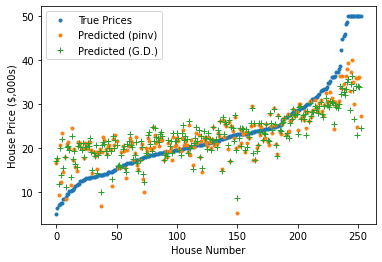

In [25]:
perm = torch.argsort(y_test, dim=0)
plt.plot(y_test[perm[:,0]].numpy(), '.', label='True Prices')
plt.plot((X_test[perm[:,0]] @ theta).numpy(), '.', label='Predicted (pinv)')
plt.plot((X_test[perm[:,0]] @ theta_gd).numpy(), '+', label='Predicted (G.D.)')
plt.xlabel('House Number')
plt.ylabel('House Price ($,000s)')
plt.legend()
plt.show()

# Part 2: Logistic Regression and Gradient Checking

In the first part of the lab we saw how to make predictions of continously varying values with a linear regression model. Lets now turn our focus to binary classification using a simple classification algorithm known as Logistic regression.

In linear regression we tried to predict the value of $y$ for an example $\mathbf{x}$ using a linear function $y=\mathbf{x}^\top\theta$ (where $\mathbf{x}$ and $\theta$ are column-vectors). This will clearly not be a great solution for predicting binary-valued labels ($y\in\{0,1\}$). In logistic regression we use a different hypothesis class to try to predict the probability that a given example belongs to the "1" class versus the probability that it belongs to the "0" class. Specifically, we will try to learn a function of the form:

\begin{align}
P(y=1|\mathbf{x}) &= \frac{1}{1 + \exp(-\mathbf{x}^\top\theta)} \equiv \sigma(\mathbf{x}^\top\theta),\\
P(y=0|\mathbf{x}) &= 1 - P(y=1|\mathbf{x}).
\end{align}
 
The function $\sigma(z) \equiv \frac{1}{1 + \exp(-z)}$ is called the "sigmoid" or "logistic" function. The sigmoid function squashes any real valued input into the range $[0,1]$ enabling us to interprete the output as a probability. Our goal is to search for a value of $\theta$ so that the probability $P(y=1|\mathbf{x})=\sigma(\mathbf{x}^\top\theta)$ is large when $\mathbf{x}$ belongs to the "1" class and small when $\mathbf{x}$ belongs to the "0" class (so that $P(y=0|\mathbf{x})$ is large). 

With Linear Regression, the natural cost function was one that measured the sum of squared residuals (the difference between the predicted value and true value). With logisitic regression we have a probabilisitic model, so it makes sense that we use a function that measures the likelihood of the data given the model (note that we want to maximise this function rather than minimise it). As an aside, note that in the case of linear regression if we assume that the data has errors that are IID (independently and identically distributed) according to a Normal distribution, then it can be shown that the maximising the likelihood is exactly the same as minimising the sum of squared residuals. For logistic regression, the likelihood function for a single data point is:

\begin{align}
p(y|\mathbf{x}; \theta) &= \sigma(\mathbf{x}^\top\theta)^y(1-\sigma(\mathbf{x}^\top\theta)^{(1-y)}.
\end{align}

(Eliminating another term when y = 0 or 1)

For a complete dataset of points $(y_i, \mathbf{x}_i)$, then the complete likelihood is:

\begin{align}
L(\theta) &= \prod_i \sigma(\mathbf{x}_i^\top\theta)^{y_i}(1-\sigma(\mathbf{x}_i^\top\theta)^{(1-y_i)}
\end{align}

However, it is considerably easier to maximise the log-likelihood function:

\begin{align}
\mathcal{l}(\theta) &= \log L(\theta) \\
                    & = \log \prod_i \sigma(\mathbf{x}_i^\top\theta)^{y_i}(1-\sigma(\mathbf{x}_i^\top\theta)^{(1-y_i)} \\
                    & = \sum_i y_i \log(\sigma(\mathbf{x}_i^\top\theta)) + (1-y_i) \log(1-\sigma(\mathbf{x}_i^\top\theta))
\end{align}

Clearly, maximising the log-likelihood is equivalent to minimising the negative log-likelihood. The negative of the log-likelihood function having the form $-\sum_i y_i \log(p) + (1-y_i) \log(p)$, where p is a function returning the predicted probability of class "1", is often called the __"Binary Cross Entropy"__ function, __"Binary Cross Entropy Loss"__ or sometimes the __"log loss"__.

For conciseness and computational efficiency, we can write the negative logistic regression log-likelihood function in matrix form. Assuming the $y_i$ are stored in a column vector $\mathbf{y}$ and the data vectors $x_i$ in the __rows__ of a matrix $\mathbf{X}$, then: 

\begin{align}
\mathrm{NLL}(\theta) & = -(\mathbf{y}^\top \log(\sigma(\mathbf{X}\theta)) + (1-\mathbf{y})^\top \log(1-\sigma(\mathbf{X}\theta)))
\end{align}

The gradients of this function are given by:

\begin{align}
\nabla_\theta \mathrm{NLL}(\theta) & = \mathbf{X}^\top(\sigma(\mathbf{X}\theta) - \mathbf{y})
\end{align}

__Use the box below to compute the gradients of the negative log-likelihood function $\nabla_\theta \mathrm{NLL}(\theta)$. You can use `torch.sigmoid()` to apply the sigmoid function.__

In [29]:
import torch

# we wouldn't normally do this, but for this lab we want to work in double precision
# as we'll need the numerical accuracy later on for doing checks on our gradients:
torch.set_default_dtype(torch.float64) 

def logistic_regression_loss_grad(theta, X, y):
    # YOUR CODE HERE
    grad = torch.mm(X.t(),(torch.sigmoid(X @ theta) - y))
    return grad

In [30]:
theta = torch.zeros(1)
X = torch.Tensor([[1]])
y = torch.Tensor([[0]])
logistic_regression_loss_grad(theta, X, y) == 0.5

tensor([[True]])

## Training a Logistic Regressor with real data

We'll now try gradient descent using our gradient function on a real dataset from `scikit-learn` called `digits`. 

The `digits` dataset contains handwritten characters (much like the `MNIST` dataset that you may have heard of - we'll explore `MNIST` in a future lab). As logistic regression is a binary classifier, we'll just use the first 2 characters (0 and 1) from the `digits` dataset, and make our own training and test splits:

In [34]:
from sklearn.datasets import load_digits

data, target = load_digits(n_class=2, return_X_y=True)
X = torch.Tensor(data)
y = torch.Tensor(target) #convert to pytorch Tensors
X = torch.cat((X, torch.ones((X.shape[0], 1))), 1) # append a column of 1's to the X's
y = y.reshape(-1, 1) # reshape y into a column vector

# We're also going to break the data into a training set for computing the regression parameters
# and a test set to evaluate the predictive ability of those parameters
perm = torch.randperm(y.shape[0])
X_train = X[perm[0:260], :]
y_train = y[perm[0:260]]
X_test = X[perm[260:], :]
y_test = y[perm[260:]]

Now we have the data, we can use our loss function to try and estimate the optimal parameters for the two-digit classification problem. We'll use `PyTorch`s `torch.nn.functional.binary_cross_entropy_with_logits` function to print out the Binary Cross Entropy of the training data at each iteration, and of the test data once the optimisation is complete. 

Note: `logits` refers to unscaled probabilities before the sigmoid is applied, so in the `binary_cross_entropy_with_logits` function we just pass in $\mathbf{X}\theta$. `PyTorch` does also have a `torch.nn.binary_cross_entropy` method that takes in probabilities, however, as we'll see when implementing neural networks in a later lab, we'll often choose to work with logits as they provide better numerical stability thanks to the _log-sum-exp_ trick. 

In [35]:
print(X_train.size())

torch.Size([260, 65])


In [36]:
alpha = 0.001
theta_gd = torch.rand((X_train.shape[1], 1))
for e in range(0, 10):
    gr = logistic_regression_loss_grad(theta_gd, X_train, y_train)
    theta_gd -= alpha * gr
    print("Epoch:", e, " BCE of training data:", torch.nn.functional.binary_cross_entropy_with_logits(X_train @ theta_gd, y_train))

print("Gradient Descent Theta:", theta_gd.t())
print("BCE of test data:", torch.nn.functional.binary_cross_entropy_with_logits(X_test @ theta_gd, y_test))

Epoch: 0  BCE of training data: tensor(70.6604)
Epoch: 1  BCE of training data: tensor(40.9157)
Epoch: 2  BCE of training data: tensor(10.6069)
Epoch: 3  BCE of training data: tensor(0.0103)
Epoch: 4  BCE of training data: tensor(0.0022)
Epoch: 5  BCE of training data: tensor(0.0007)
Epoch: 6  BCE of training data: tensor(0.0004)
Epoch: 7  BCE of training data: tensor(0.0003)
Epoch: 8  BCE of training data: tensor(0.0002)
Epoch: 9  BCE of training data: tensor(0.0002)
Gradient Descent Theta: tensor([[ 0.8178,  0.8849,  0.0442, -0.7175, -0.1383,  0.9468,  0.5034,  0.3890,
          0.7860,  0.4214, -1.3169, -0.4351,  0.0959, -0.0233,  0.9525,  0.8439,
          0.4454,  0.1152, -1.7166,  1.5928,  2.2634, -1.1212, -0.4840,  0.5561,
          0.5700, -0.3865, -0.4834,  2.9374,  2.8723, -0.5896, -0.9949,  0.6594,
          0.2673, -0.8247, -1.0694,  2.1128,  3.3307, -0.3576, -0.8857,  0.3952,
          0.3675, -0.3407, -1.3731,  2.4717,  3.0764, -0.7557, -0.7338,  0.1468,
          0.0074,

What do you observe from running the above? 

## Gradient Checking

How can we be sure that our gradient function was correct? We might have made an error in the analytical derivation or in the implementation of that derivation into code. Even though we observed the optimisation process on real data converge (hopefully!), you might have made a subtle error in the implementation...

So far we have worked with relatively simple algorithms where it is straightforward to compute the objective function and its gradient with pen-and-paper, and then implement the necessary computations in PyTorch. For more complex models that we will see later, the gradient computation can be notoriously difficult to debug and get right. Sometimes a subtly buggy implementation will manage to learn something that can look surprisingly reasonable (while performing less well than a correct implementation). Thus, even with a buggy implementation, it may not at all be apparent that anything is amiss. In this section, we describe a method for numerically checking the derivatives computed by your code to make sure that your implementation is correct. Carrying out the derivative checking procedure described here will significantly increase your confidence in the correctness of your code.

Suppose we want to minimize $J(\theta)$ as a function of $\theta$. For this example, suppose $J:\mathbb{R}\mapsto\mathbb{R}$, so that $\theta \in \mathbb{R}$. If we are using gradient descent (or other gradient-based optimisation function), then we usually have implemented some function $g(\theta)$ that purportedly computes $\frac{d}{d\theta}J(\theta)$.

How can we check if our implementation of $g$ is correct?

Recall the mathematical definition of the derivative is:

\begin{align}
\frac{d}{d\theta}J(\theta) = \lim_{\epsilon \rightarrow 0}
\frac{J(\theta+ \epsilon) - J(\theta-\epsilon)}{2 \epsilon}.
\end{align}

Thus, at any specific value of $\theta$, we can numerically approximate the derivative as follows:

\begin{align}
\frac{J(\theta+{\rm EPSILON}) - J(\theta-{\rm EPSILON})}{2 \times {\rm EPSILON}}
\end{align}
 
In practice, we set ${\rm EPSILON}$ to a small constant, say around $10^{−4}$. (There is a large range of values of EPSILON values that should work well, but we don’t set ${\rm EPSILON}$ to be "extremely" small, say $10^{−20}$, as that would lead to numerical roundoff errors.)

Thus, given a function $g(\theta)$ that is supposedly computing $\frac{d}{d\theta}J(\theta)$, we can now numerically verify its correctness by checking that

\begin{align}
g(\theta) \approx
\frac{J(\theta+{\rm EPSILON}) - J(\theta-{\rm EPSILON})}{2 \times {\rm EPSILON}}.
\end{align}
 
The degree to which these two values should approximate each other will depend on the details of $J$. But assuming ${\rm EPSILON}=10^{−4}$, you’ll usually find that the left- and right-hand sides of the above will agree to at least 4 significant digits (and often many more).

Now, consider the case where $\theta \in \mathbb{R}^n$ is a vector rather than a single real number (so that we have $n$ parameters that we want to learn), and $J: \mathbb{R}^n \mapsto \mathbb{R}$. We now generalize our derivative checking procedure to the case where $\theta$ may be a vector (as in our linear regression and logistic regression examples).

Suppose we have a function $g_i(\theta)$ that purportedly computes $\frac{\partial}{\partial\theta_i}J(\theta)$; we’d like to check if $g_i$ is outputting correct derivative values. Let $\textstyle \theta^{(i+)} = \theta + {\rm EPSILON} \times \vec{e}_i$, where

\begin{align}
\vec{e}_i = \begin{bmatrix}0 \\ 0 \\ \vdots \\ 1 \\ \vdots \\ 0\end{bmatrix}
\end{align}

is the $i$-th basis vector (a vector of the same dimension as $\theta$, with a "1" in the $i$-th position and "0"s everywhere else). So, $\theta^{(i+)}$ is the same as $\theta$, except its $i$-th element has been incremented by ${\rm EPSILON}$. Similarly, let $\theta^{(i−)}=\theta−{\rm EPSILON} \times \vec{e}_i$ be the corresponding vector with the $i$-th element decreased by ${\rm EPSILON}$.

We can now numerically verify $g_i(\theta)$'s correctness by checking, for each $i$, that:

\begin{align}
g_i(\theta) \approx
\frac{J(\theta^{(i+)}) - J(\theta^{(i-)})}{2 \times {\rm EPSILON}}.
\end{align}

### Gradient checker code

The following code block contains an implementation of the gradient checking proceedure described above. 

In [54]:
from random import randrange

def grad_check(f, x, analytic_grad, num_checks=10, h=1e-5):
    sum_error = 0
    for i in range(num_checks):
        ix = tuple([randrange(m) for m in x.shape]) #randomly sample value to change

        oldval = x[ix].item()
        x[ix] = oldval + h # increment by h
        fxph = f(x) # evaluate f(x + h)
        x[ix] = oldval - h # increment by h
        fxmh = f(x) # evaluate f(x - h)
        x[ix] = oldval # reset

        grad_numerical = (fxph - fxmh) / (2 * h)
        grad_analytic = analytic_grad[ix]
        rel_error = abs(grad_numerical - grad_analytic) / (abs(grad_numerical) + abs(grad_analytic) + 1e-8)
        sum_error += rel_error
        print('numerical: %f\tanalytic: %f\trelative error: %e' % (grad_numerical, grad_analytic, rel_error))
    return sum_error / num_checks

To use the gradient checker, we provide our analytical gradients, together with a function that computes the actual loss (rather than the gradients of the loss) and the parameters at which the gradient was computed:

In [55]:
#we'll use random parameters:
theta = torch.rand_like(theta_gd)*0.001
# and compute the analytic gradient (w.r.t the test data we loaded in this case)
grad = logistic_regression_loss_grad(theta, X_test, y_test)

# we need a function that computes the loss for a given theta (and implicitly the data)
def func(th):
    sigm = torch.sigmoid(X_test @ th)
    f = -(y_test.t() @ torch.log(sigm) + (1 - y_test.t()) @ torch.log(1 - sigm));
    return f

# and run the gradient checker
relerr = grad_check(func, theta, grad)
print("average error:", relerr)

relerr < 1e-5

numerical: -231.144800	analytic: -231.144800	relative error: 7.637085e-11
numerical: 96.512932	analytic: 96.512932	relative error: 6.578376e-12
numerical: 4.632942	analytic: 4.632942	relative error: 7.851553e-12
numerical: 0.528250	analytic: 0.528250	relative error: 9.163149e-11
numerical: 96.512932	analytic: 96.512932	relative error: 6.578376e-12
numerical: 179.022446	analytic: 179.022446	relative error: 1.451443e-10
numerical: 87.635239	analytic: 87.635239	relative error: 4.745448e-10
numerical: 0.000000	analytic: 0.000000	relative error: 0.000000e+00
numerical: 0.169199	analytic: 0.169199	relative error: 2.360763e-09
numerical: 120.254724	analytic: 120.254724	relative error: 2.385832e-10
average error: tensor([[3.4080e-10]])


tensor([[True]])

Running the above, you should have a very small average error, and the relative error for each trial should also be a very small value.

# Part 3: Softmax Regression

In the second part of the lab we saw how to make a linear binary classifier using logisitic regression. In this  part of the lab we'll turn our attention to multi-class classification.

Softmax regression (or multinomial logistic regression) is a generalisation of logistic regression to the case where we want to handle multiple classes. In logistic regression we assumed that the labels were binary: $y_i\in \{0,1\}$. We used such a classifier to distinguish between two kinds of hand-written digits. Softmax regression allows us to handle $y_i \in \{1,\dots,K\}$ where $K$ is the number of classes.

Recall that in logistic regression, we had a training set $\{(\mathbf{x}_1,y_1),\dots,(\mathbf{x}_m,y_m)\}$ of $m$ labeled examples, where the input features are $\mathbf{x}_i \in \mathbb{R}^n$. In logistic regression, our hypothesis took the form:

\begin{align}
h_\theta(\mathbf{x}) &= \frac{1}{1 + \exp(-\mathbf{x}^\top\theta)} \equiv \sigma(\mathbf{x}^\top\theta)
\end{align}

and the model parameters $\theta$ were trained to minimise the cost function

\begin{align}
J(\theta) & = \sum_i y_i \log(\sigma(\mathbf{x}_i^\top\theta)) + (1-y_i) \log(1-\sigma(\mathbf{x}_i^\top\theta))
\end{align}

In the softmax regression setting, we are interested in multi-class classification, and so the label $y$
 can take on $K$ different values, rather than only two. Thus, in our training set $\{(\mathbf{x}_1,y_1),\dots,(\mathbf{x}_m,y_m)\}$, we now have that $y_i \in \{1,\dots,K\}$.

Given a test input $\mathbf{x}$, we want our hypothesis to estimate the probability that $P(y=k|\mathbf{x})$ for each value of $k=1,\dots,K$. That is to say, we want to estimate the probability of the class label taking on each of the $K$ different possible values. Thus, our hypothesis will output a $K$-dimensional vector (whose elements sum to 1) giving us our $K$ estimated probabilities. Concretely, our hypothesis $h_\theta(\mathbf{x})$ takes the form:

\begin{align}
h_\theta(\mathbf{x}) =
\begin{bmatrix}
P(y = 1 | \mathbf{x}; \theta) \\
P(y = 2 | \mathbf{x}; \theta) \\
\vdots \\
P(y = K | \mathbf{x}; \theta)
\end{bmatrix}
=
\frac{1}{ \sum_{j=1}^{K}{\exp(\theta^{(j)\top} \mathbf{x}) }}
\begin{bmatrix}
\exp(\theta^{(1)\top} \mathbf{x} ) \\
\exp(\theta^{(2)\top} \mathbf{x} ) \\
\vdots \\
\exp(\theta^{(K)\top} \mathbf{x} ) \\
\end{bmatrix}
\end{align}

Here $\theta^{(1)},\theta^{(2)},\dots,\theta^{(K)} \in \mathbb{R}^n$ are the parameters of our model. Notice that the term $\frac{1}{\sum_{j=1}^K exp(\theta^{(j)\top} \mathbf{x})}$ normalizes the distribution, so that it sums to one.

For convenience, we will also write $\theta$ to denote all the parameters of our model. When you implement softmax regression, it is usually convenient to represent $\theta$ as a $n$-by-$K$ matrix obtained by concatenating $\theta_{(1)},\theta^{(2)},\dots,\theta^{(K)}$ into columns, so that

\begin{align}
\theta = \left[\begin{array}{cccc}| & | & | & | \\
\theta^{(1)} & \theta^{(2)} & \cdots & \theta^{(K)} \\
| & | & | & |
\end{array}\right].
\end{align}


## Cost Function

We now describe the cost function that we’ll use for softmax regression. In the equation below, $1\{\cdot\}$
 is an "indicator function", such that $1\{\mathrm{a true statement}\}=1$, and $1\{\mathrm{a false statement}\}=0$. For example, $1\{2+2=4\}$ evaluates to $1$; whereas $1\{1+1=5\}$ evaluates to $0$. Our cost function will be:

\begin{align}
J(\theta) = - \left[ \sum_{i=1}^{m} \sum_{k=1}^{K}  1\left\{y_{i} = k\right\} \log \frac{\exp(\theta^{(k)\top} \mathbf{x}_i)}{\sum_{j=1}^K \exp(\theta^{(j)\top} \mathbf{x}_i)}\right]
\end{align}
 
Notice that this generalises the logistic regression cost function, which could also have been written:

\begin{align}
J(\theta) &= - \left[ \sum_{i=1}^m   (1-y^{(i)}) \log (1-h_\theta(\mathbf{x}_i)) + y^{(i)} \log h_\theta(\mathbf{x}_i) \right] \\
&= - \left[ \sum_{i=1}^{m} \sum_{k=0}^{1} 1\left\{y^{(i)} = k\right\} \log P(y^{(i)} = k | \mathbf{x}_i ; \theta) \right]
\end{align}


The softmax cost function is similar, except that we now sum over the $K$ different possible values of the class label. Note also that in softmax regression, we have that

\begin{equation}
P(y_i = k | \mathbf{x}_i ; \theta) = \frac{\exp(\theta^{(k)\top} \mathbf{x}_i)}{\sum_{j=1}^K \exp(\theta^{(j)\top} \mathbf{x}_i) }
\end{equation}

We cannot solve for the minimum of $J(\theta)$ analytically, and thus we'll resort to using gradient descent as before. Taking derivatives, one can show that the gradient is:

\begin{align}
\nabla_{\theta^{(k)}} J(\theta) = - \sum_{i=1}^{m}{ \left[ \mathbf{x}_i \left( 1\{ y_i = k\}  - P(y_i = k | \mathbf{x}_i; \theta) \right) \right]  }
\end{align}

Armed with this formula for the derivative, one can then use it directly with a gradient descent solver (or any other 1st-order gradient based optimiser).

__Use the code box below to complete the implementation of the functions that return the gradients of the softmax loss function, $\nabla_{\theta^{(k)}} J(\theta) \,\, \forall k$ and the loss function itself, $J(\theta)$:__

In [101]:
import torch

# we wouldn't normally do this, but for this lab we want to work in double precision
# as we'll need the numerical accuracy later on for doing checks on our gradients:
torch.set_default_dtype(torch.float64) 

def softmax_regression_loss_grad(Theta, X, y):
    '''Implementation of the gradient of the softmax loss function.
    
    Theta is the matrix of parameters, with the parameters of the k-th class in the k-th column
    X contains the data vectors (one vector per row)
    y is a column vector of the targets
    '''
    # YOUR CODE HERE
    m = X.shape[0]
    n = X.shape[1]
    k = Theta.shape[1]
    Sum = torch.sum(torch.exp(X@Theta),dim = 1,keepdim = False)
    grad = torch.zeros((m,n))
    for i in range(k):
        for j in range(m):
            P = torch.exp(Theta[:,i]@X[j,:])/Sum[j]
            l = 1* (y[j] == i)
            grad[i] -= X[j,:]*(l-P)
#     raise NotImplementedError()

    return grad

def softmax_regression_loss(Theta, X, y):
    '''Implementation of the softmax loss function.
        
    Theta is the matrix of parameters, with the parameters of the k-th class in the k-th column
    X contains the data vectors (one vector per row)
    y is a column vector of the targets
    '''
    # YOUR CODE HERE
    m = X.shape[0]
    k = Theta.shape[1]
    Sum = torch.sum(torch.exp(X@Theta),dim = 1,keepdim = False)
    LossMatrix = torch.zeros((m,1))
    for i in range(m):
        for j in range(k):
            P = torch.exp(Theta[:,j]@X[i,:])/Sum[i]
            l = 1* (y[i] == j)
            LossMatrix[i] -= l * torch.log(P)
    loss = torch.sum(LossMatrix)
#     raise NotImplementedError()

    return loss

__Use the following code block to confirm that your implementation is correct using gradient checking. If there are problems with your gradient or loss, go back and fix them!:__

In [102]:
 # from torch.autograd import gradcheck
from random import randrange

def grad_check(f, x, analytic_grad, num_checks=10, h=1e-3):
    sum_error = 0
    for i in range(num_checks):
        ix = tuple([randrange(m) for m in x.shape]) #randomly sample value to change

        oldval = x[ix].item()
        x[ix] = oldval + h # increment by h
        fxph = f(x) # evaluate f(x + h)
        x[ix] = oldval - h # increment by h
        fxmh = f(x) # evaluate f(x - h)
        x[ix] = oldval # reset

        grad_numerical = (fxph - fxmh) / (2 * h)
        grad_analytic = analytic_grad[ix]
        rel_error = abs(grad_numerical - grad_analytic) / (abs(grad_numerical) + abs(grad_analytic) + 1e-8)
        sum_error += rel_error
        print('numerical: %f\tanalytic: %f\trelative error: %e' % (grad_numerical, grad_analytic, rel_error))
    return sum_error / num_checks

# Create some test data:
num_classes = 10
features_dim = 20
num_items = 100
Theta = torch.randn((features_dim, num_classes))
X = torch.randn((num_items,features_dim))
y = torch.torch.randint(0, num_classes, (num_items, 1))

# compute the analytic gradient
grad = softmax_regression_loss_grad(Theta, X, y)
    
# run the gradient checker    
grad_check(lambda th: softmax_regression_loss(th, X, y), Theta, grad)

numerical: 4.324310	analytic: 4.324310	relative error: 1.262269e-08
numerical: -12.628893	analytic: -4.519325	relative error: 4.729103e-01
numerical: 1.721391	analytic: -1.730062	relative error: 1.000000e+00
numerical: -1.283641	analytic: 0.000000	relative error: 1.000000e+00
numerical: -3.584145	analytic: 0.000000	relative error: 1.000000e+00
numerical: 4.318839	analytic: 0.000000	relative error: 1.000000e+00
numerical: 1.226058	analytic: 0.000000	relative error: 1.000000e+00
numerical: -18.543648	analytic: -0.206529	relative error: 9.779704e-01
numerical: -1.958505	analytic: 0.000000	relative error: 1.000000e+00
numerical: -1.407731	analytic: 0.000000	relative error: 1.000000e+00


tensor(0.8451)

In [103]:
Theta = torch.Tensor([[1, 0], [0, 1]])
X = torch.Tensor([[1, 0], [0, 1]])
y = torch.LongTensor([[0], [1]])
assert torch.abs(softmax_regression_loss(Theta, X, y) - 0.6265) < 0.0001
grad = softmax_regression_loss_grad(Theta, X, y)
assert torch.torch.allclose(torch.abs(grad/0.2689), torch.ones_like(grad), atol=0.001)

## Training Softmax regression with gradient descent on real data

We'll now try gradient descent with our softmax regression using the digits dataset. As before, when we looked at logistic regression, we load the data and create test and training sets. Note that this time we'll use all the classes:

In [110]:
from sklearn.datasets import load_digits

data, target = load_digits(n_class=10, return_X_y=True)
X = torch.Tensor(data)
y = torch.Tensor(target) #convert to pytorch Tensors
X = torch.cat((X, torch.ones((X.shape[0], 1))), 1) # append a column of 1's to the X's
X /= 255
y = y.reshape(-1, 1) # reshape y into a column vector
y = y.type(torch.LongTensor)

# We're also going to break the data into a training set for computing the regression parameters
# and a test set to evaluate the predictive ability of those parameters
perm = torch.randperm(y.shape[0])
X_train = X[perm[0:260], :]
y_train = y[perm[0:260]]
X_test = X[perm[260:], :]
y_test = y[perm[260:]]

X_train.size()

torch.Size([260, 65])

We now define a simple gradient descent loop to train the model:

In [108]:
alpha = 0.1
theta_gd = torch.rand((X_train.shape[1], 10))
theta_gd.size()
for e in range(0, 1000):
    gr = softmax_regression_loss_grad(theta_gd, X_train, y_train)
    theta_gd -= alpha * gr
    if e%100 == 0:
        print("Training Loss: ", softmax_regression_loss(theta_gd, X_train, y_train))

# Compute the accuracy of the test set
proba = torch.softmax(X_test @ theta_gd, 1)
print(float((proba.argmax(1)-y_test[:,0]==0).sum()) / float(proba.shape[0]))


RuntimeError: The size of tensor a (10) must match the size of tensor b (65) at non-singleton dimension 1

# Overparameterisation in softmax regression

Softmax regression has an unusual property that it has a "redundant" set of parameters. To explain what this means, suppose we take each of our parameter vectors $\theta^{(j)}$, and subtract some fixed vector $\psi$ from it, so that every $\theta^{(j)}$ is now replaced with $\theta^{(j)}−\psi$ (for every $j=1,\dots,k$). Our hypothesis now estimates the class label probabilities as

\begin{align}
P(y^{(i)} = k | x^{(i)} ; \theta)
&= \frac{\exp((\theta^{(k)}-\psi)^\top x^{(i)})}{\sum_{j=1}^K \exp( (\theta^{(j)}-\psi)^\top x^{(i)})}  \\
&= \frac{\exp(\theta^{(k)\top} x^{(i)}) \exp(-\psi^\top x^{(i)})}{\sum_{j=1}^K \exp(\theta^{(j)\top} x^{(i)}) \exp(-\psi^\top x^{(i)})} \\
&= \frac{\exp(\theta^{(k)\top} x^{(i)})}{\sum_{j=1}^K \exp(\theta^{(j)\top} x^{(i)})}.
\end{align}

__In other words, subtracting $\psi$ from every $\theta^{(j)}$ does not affect our hypothesis’ predictions at all!__ This shows that softmax regression’s parameters are "redundant". More formally, we say that our softmax model is "overparameterised" meaning that for any hypothesis we might fit to the data, there are multiple parameter settings that give rise to exactly the same hypothesis function $h_\theta$ mapping from inputs $\mathbf{x}$ to the predictions.

Further, if the cost function $J(\theta)$ is minimized by some setting of the parameters $(\theta^{(1)},\theta^{(2)},\dots,\theta^{(k)})$, then it is also minimised by $\theta^{(1)}-\psi,\theta^{(2)}-\psi,\dots,\theta^{(k)}-\psi)$ for any value of $\psi$. Thus, the minimiser of $J(\theta)$ is not unique. 

(Interestingly, $J(\theta)$ is still convex, and thus gradient descent will not run into local optima problems. The Hessian is however singular/non-invertible, which causes a straightforward implementation of Newton's method (a second-order optimiser) to run into numerical problems.)

Notice also that by setting $\psi=\theta^{(K)}$, one can always replace $\theta^{(K)}$ with $\theta^{(K)}-\psi=\mathbf{0}$ (the vector of all $0$’s), without affecting the hypothesis. Thus, one could "eliminate" the vector of parameters $\theta^{(K)}$ (or any other $\theta^{(k)}$, for any single value of $k$), without harming the representational power of our hypothesis. Indeed, rather than optimising over the $K \cdot n$ parameters $(\theta^{(1)},\theta^{(2)},\dots,\theta^{(k)})$  (where $\theta^{(k)} \in \mathbb{R}^n$, one can instead set $\theta^{(K)}=\mathbf{0}$  and optimize only with respect to the $(K-1) \cdot n$ remaining parameters.

__Use the following block to implement the softmax gradients for the case where the final column of the parameters theta is fixed to be zero:__

In [111]:
import torch

def softmax_regression_loss_grad_0(Theta, X, y):
    '''Implementation of the gradient of the softmax loss function, with the parameters of the
    last class fixed to be zero.
    
    Theta is the matrix of parameters, with the parameters of the k-th class in the k-th column; 
            K-1 classes are included, and the parameters of the last class are implicitly zero.
    X contains the data vectors (one vector per row)
    y is a column vector of the targets
    '''
    
    # add the missing column of zeros:
    Theta = torch.cat((Theta, torch.zeros(Theta.shape[0],1)), 1)

    # YOUR CODE HERE
    raise NotImplementedError()
    
    # remove the last column from the gradients
    grad = grad[0:grad.shape[0], 0:grad.shape[1]-1]
    return grad

In [112]:
Theta = torch.Tensor([[1, 0], [0, 0]])
X = torch.Tensor([[1, 0], [0, 1]])
y = torch.LongTensor([[0], [1]])

grad = softmax_regression_loss_grad(Theta, X, y)
grad0 = softmax_regression_loss_grad_0(Theta[:,0:grad.shape[1]-1], X, y)
assert torch.torch.allclose(grad[:,0:grad.shape[1]-1], grad0)


NotImplementedError: 

In [113]:
alpha = 0.1
theta_gd = torch.rand((X_train.shape[1], 9))

for e in range(0, 1000):
    gr = softmax_regression_loss_grad_0(theta_gd, X_train, y_train)
    theta_gd -= alpha * gr

theta_gd = torch.cat((theta_gd, torch.zeros(theta_gd.shape[0], 1)), 1)
proba = torch.softmax(X_test @ theta_gd, 1)
print(float((proba.argmax(1)-y_test[:,0]==0).sum()) / float(proba.shape[0]))


NotImplementedError: 

Finally, we can run gradient descent with our reduced paramter gradient function, and confirm that the results are similar to before:

In [3]:
import torch

In [4]:
a = torch.randn(3,3)

In [5]:
a

tensor([[ 0.7886, -1.3492,  0.9777],
        [-0.0462, -0.2879, -1.0416],
        [-0.1155,  0.4664, -0.1692]])

In [6]:
a[0,:]

tensor([ 0.7886, -1.3492,  0.9777])

In [7]:
b = torch.randn(3,3)
b

tensor([[-1.0305, -0.6596,  0.1758],
        [-0.3989,  0.6862, -0.6219],
        [ 0.8953,  1.1149, -0.1720]])

In [8]:
a@b

tensor([[ 0.6010, -0.3560,  0.8096],
        [-0.7701, -1.3284,  0.3501],
        [-0.2185,  0.2077, -0.2813]])

In [9]:
a*b

tensor([[-0.8127,  0.8900,  0.1719],
        [ 0.0184, -0.1976,  0.6478],
        [-0.1034,  0.5200,  0.0291]])

In [10]:
torch.mm(a,b)

tensor([[ 0.6010, -0.3560,  0.8096],
        [-0.7701, -1.3284,  0.3501],
        [-0.2185,  0.2077, -0.2813]])

In [63]:
b[:,0]


tensor([-0.3925, -0.7487, -0.8038])

In [64]:
b[:,0]*3

tensor([-1.1774, -2.2462, -2.4115])

In [81]:
grad = torch.zeros((100,3))
grad[0]=(b [:,0]*3)
grad

tensor([[-1.1774, -2.2462, -2.4115],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
 

In [52]:
b[:,0].t()*a[0,:]

tensor([-0.4470, -1.3650, -0.6870])

In [56]:
b[:,0]@a[0,:]

tensor(-2.4990)

In [53]:
torch.exp(b[:,0].t()*a[0,:])

tensor([0.6396, 0.2554, 0.5031])

In [ ]:
torch.exp(b[:,0].t()*a[0,:])

In [40]:
torch.exp(a)

tensor([[3.1233, 6.1912, 2.3505],
        [0.8020, 1.3653, 5.4525],
        [1.4036, 0.3809, 0.6920]])

In [47]:
Sum = torch.sum(torch.exp(a),dim=1 , keepdim = False)

In [83]:
Sum = torch.sum(torch.exp(a))

In [84]:
Sum

tensor(21.7612)

In [59]:
Sum[0]

tensor(11.6649)

In [1]:
a = 1
b = 1
a == b
1* (a==b)

1